In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mtp
mtp.rcParams["pdf.fonttype"] = 42

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
hnsc_rnaseq = pd.read_csv("C:/Data/Lab/ZanettiLab/HNSC_TERT_project/data/rna_seq/hnsc_all.rawcounts.csv",index_col=0)
brca_rnaseq = pd.read_csv("C:/Data/Lab/ZanettiLab/HNSC_TERT_project/data/rna_seq/brca_all.rawcounts.csv",index_col=0)

hnsc_rnaseq.dropna(subset = ["genes"],inplace = True)
hnsc_rnaseq.set_index("genes",inplace = True)
tert_exp = hnsc_rnaseq.loc["TERT"]
tert_cut = pd.cut(tert_exp, bins = [-np.inf, np.quantile(tert_exp,q = .3), np.quantile(tert_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

bcell = ["CD19","MS4A1"]
b_exp = sp.stats.gmean(hnsc_rnaseq.loc[bcell])
b_cut = pd.cut(b_exp, bins = [-np.inf, np.quantile(b_exp,q = .3), np.quantile(b_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

bhi_terthi = np.where((b_cut == "HIGH") & (tert_cut == "HIGH"))[0]
bhi_terthi = list(hnsc_rnaseq.columns[bhi_terthi])
bhi_tertlo = np.where((b_cut == "HIGH") & (tert_cut == "LOW"))[0]
bhi_tertlo = list(hnsc_rnaseq.columns[bhi_tertlo])

genelist = """BCL2, CD22, CD320, CD40, CD79B, PAX5, BATF, IL21R, IL27RA, IL2RG, IL1R2, LCK, VCAM1, ZAP70, CCL19, CCL20, CXCR4, GZMA, GZMB, LTB, PRF1, ANGPTL2, CD109, CCL2, CCL22, IL33, ITGA7, PCSK5, PCSK6, TGFBR2, TGFBR3, AREG, IGF2""".split(", ")
# 
# removed TGFB1

# Supplementary 3

In [4]:
hpv_clinic_cbioportal = pd.read_csv("C:/Users/mistu/Downloads/hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv",sep = "\t")
hpv_pos_ids = [ x.split("-")[2] for x in hpv_clinic_cbioportal[hpv_clinic_cbioportal["Subtype"] == "HNSC_HPV+"]["Patient ID"].tolist()]

tcga_mapped_id = pd.read_csv("https://raw.githubusercontent.com/andreabc/TCGA_UUID_barcode_mapping/master/uuid_barcode_map.txt",sep = "\t")
map_d = {x.split(".")[0]: y for x,y in zip(tcga_mapped_id["file_name"],tcga_mapped_id["sample_barcode"])}

bhi_terthi = [map_d[x.split(".")[0]].split("-")[2] for x in bhi_terthi]
bhi_tertlo = [map_d[x.split(".")[0]].split("-")[2] for x in bhi_tertlo]

hnsc_rnaseq.columns = [map_d[x.split(".")[0]].split("-")[2] for x in hnsc_rnaseq.columns]

hnsc_exp = hnsc_rnaseq.loc[["APOBEC3B","AICDA"]][bhi_terthi + bhi_tertlo]
hnsc_exp = hnsc_exp.T
hnsc_exp["HPV"] = ["Positive" if x in set(hpv_pos_ids) else "Negative" for x in hnsc_exp.index.tolist()]
hnsc_exp["type"] = ["BhiTERThi" if x in bhi_terthi else "BhiTERTlo" for x in hnsc_exp.index.tolist()]

In [5]:
def plot_box_rnaseq_counts(gene, hpv = '',limit = (10**1.5,10**4.2)):
    plt.figure(figsize = (2,4))
    
    if hpv=="Negative":
        data = hnsc_exp[hnsc_exp["HPV"] == "Negative"]
    elif hpv == "Positive":
        data = hnsc_exp[hnsc_exp["HPV"] == "Positive"]
    else:
        data = hnsc_exp
    sns.boxplot(x = "type", y = gene, data = data,
               palette = [sns.color_palette("tab10")[1],sns.color_palette("tab10")[0]],
                order = ["BhiTERThi","BhiTERTlo"])
    plt.yscale("log")
    plt.ylim(limit)
    
    
    if hpv == "Negative":
        print("log2fc")
        print(np.log2(hnsc_exp[(hnsc_exp["type"] == "BhiTERThi") & (hnsc_exp["HPV"] == "Negative")][gene].median()/hnsc_exp[(hnsc_exp["type"] == "BhiTERTlo") & (hnsc_exp["HPV"] == "Negative")][gene].median()))
        
        print("p-value")
        
        print(sp.stats.ranksums(hnsc_exp[(hnsc_exp["type"] == "BhiTERThi") & (hnsc_exp["HPV"] == "Negative")][gene],
         hnsc_exp[(hnsc_exp["type"] == "BhiTERTlo") & (hnsc_exp["HPV"] == "Negative") ][gene]))
        
    elif hpv == "Positive":
            
        print("log2fc")
        print(np.log2(hnsc_exp[(hnsc_exp["type"] == "BhiTERThi") & (hnsc_exp["HPV"] == "Positive")][gene].median()/hnsc_exp[(hnsc_exp["type"] == "BhiTERTlo") & (hnsc_exp["HPV"] == "Positive")][gene].median()))

        print("p-value")
        print(sp.stats.ranksums(hnsc_exp[(hnsc_exp["type"] == "BhiTERThi") & (hnsc_exp["HPV"] == "Positive") ][gene],
         hnsc_exp[(hnsc_exp["type"] == "BhiTERTlo") & (hnsc_exp["HPV"] == "Positive") ][gene]))

    else:
        print("log2fc")
        print(np.log2(hnsc_exp[(hnsc_exp["type"] == "BhiTERThi")][gene].median()/hnsc_exp[(hnsc_exp["type"] == "BhiTERTlo")][gene].median()))

        print("p-value")

        print(sp.stats.ranksums(hnsc_exp[(hnsc_exp["type"] == "BhiTERThi") ][gene],
        hnsc_exp[(hnsc_exp["type"] == "BhiTERTlo") ][gene]))
    

log2fc
0.8698327077954222
p-value
RanksumsResult(statistic=2.9234299525979814, pvalue=0.0034619810982170064)


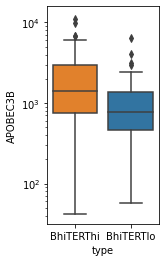

In [6]:
plot_box_rnaseq_counts("APOBEC3B")

log2fc
1.8458513893109787
p-value
RanksumsResult(statistic=1.1832159566199232, pvalue=0.23672357063785732)


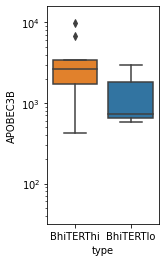

In [7]:
plot_box_rnaseq_counts("APOBEC3B",hpv= "Positive")

log2fc
0.4758750849313217
p-value
RanksumsResult(statistic=2.3901305208822508, pvalue=0.016842386125241103)


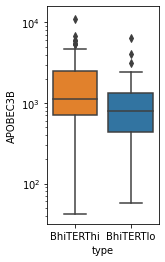

In [8]:
plot_box_rnaseq_counts("APOBEC3B",hpv= "Negative")

log2fc
0.8073549220576041
p-value
RanksumsResult(statistic=2.681382526415138, pvalue=0.007331865179518946)


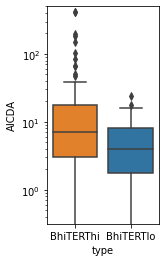

In [9]:
plot_box_rnaseq_counts("AICDA",hpv= "",limit=(10**-.5,10**2.7))

log2fc
0.5849625007211562
p-value
RanksumsResult(statistic=2.5858577446395374, pvalue=0.009713701158905364)


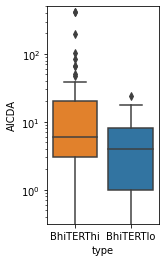

In [10]:
plot_box_rnaseq_counts("AICDA",hpv= "Negative",limit=(10**-.5,10**2.7))

log2fc
0.8073549220576041
p-value
RanksumsResult(statistic=0.3380617018914066, pvalue=0.7353166906373405)


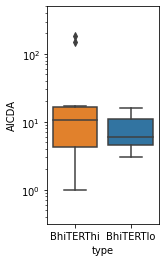

In [11]:
plot_box_rnaseq_counts("AICDA",hpv= "Positive",limit=(10**-.5,10**2.7))

# Supplementary 4

In [12]:
def tnbc_classify(df):
    tnbc_list = []
    for i,row in df.iterrows():
        if (row["pr_status_by_ihc"] == "Negative" or row["er_status_by_ihc"] == "Negative") and row["her2_status_by_ihc"] == "Negative":
            tnbc_list.append("Positive")
        else:
            tnbc_list.append("Negative")
    return tnbc_list
brca_subtypes = pd.read_csv("C:/Data/Lab/ZanettiLab/brca/nationwidechildrens.org_clinical_patient_brca.txt",sep = "\t")
brca_subtypes["TNBC"] = tnbc_classify(brca_subtypes)

In [13]:
fdir = "C:/Data/Lab/ZanettiLab/HNSC_TERT_project/data/"
tcga_tls = pd.read_csv(fdir + "TCGA_TLS.txt",sep = "\t")
tcgaDf = pd.read_csv("C:/Data/Lab/CarterLab/aneuploidy_data/TCGA_TP_allgene.csv")
tcga_tls["patient_id"] = [x.split(".")[2] for x in tcga_tls["id"]]

def tls_read_helper(tumor_type):
    
    f = tcgaDf[tcgaDf.disease == tumor_type.upper()].set_index("patient_id").T
    
    refgene = "TERT"
    
    tert_exp = f.loc[refgene]
    tert_cut = pd.cut(tert_exp, bins = [-np.inf, np.quantile(tert_exp,q = .3), np.quantile(tert_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

    bcell = ["CD19","MS4A1"]
    b_exp = sp.stats.gmean(f.loc[bcell].apply(pd.to_numeric))
    b_cut = pd.cut(b_exp, bins = [-np.inf, np.quantile(b_exp,q = .3), np.quantile(b_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

    bhi_terthi = np.where((b_cut == "HIGH") & (tert_cut == "HIGH"))[0]
    bhi_terthi = list(f.columns[bhi_terthi])
    bhi_tertlo = np.where((b_cut == "HIGH") & (tert_cut == "LOW"))[0]
    bhi_tertlo = list(f.columns[bhi_tertlo])
    
    return bhi_terthi, bhi_tertlo

def tls_violinplot(diseaselist = ["hnsc","lihc","lusc","luad","blca","skcm","cesc","coad","read","gbm","brca"]):
    dfplot = pd.DataFrame(columns = ["TLS score","type","disease"])
    idx_set = set(tcga_tls["patient_id"])
    df = pd.DataFrame(tcga_tls.groupby("patient_id")["TLS score"].mean())
    for disease in diseaselist:
        print(disease)
        bhi_terthi, bhi_tertlo = tls_read_helper(disease)
        bhi_terthi, bhi_tertlo = list(idx_set.intersection(bhi_terthi)), list(idx_set.intersection(bhi_tertlo))
        
        score = list(df.loc[bhi_terthi]["TLS score"]) + list(df.loc[bhi_tertlo]["TLS score"])
        dftmp = pd.DataFrame({"TLS score" : score,
                              "type" : ["bhi_terthi"] * len(bhi_terthi) + ["bhi_tertlo"] * len(bhi_tertlo),
                              "disease" : [disease] * len(score)})

        dfplot = pd.concat([dfplot, dftmp])
    return dfplot

def _helper_bhiterthi(f):
    f = f.T
    refgene = "TERT"
    tert_exp = f.loc[refgene]
    tert_cut = pd.cut(tert_exp, bins = [-np.inf, np.quantile(tert_exp,q = .3), np.quantile(tert_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

    bcell = ["CD19","MS4A1"]
    b_exp = sp.stats.gmean(f.loc[bcell].apply(pd.to_numeric))
    b_cut = pd.cut(b_exp, bins = [-np.inf, np.quantile(b_exp,q = .3), np.quantile(b_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

    bhi_terthi = np.where((b_cut == "HIGH") & (tert_cut == "HIGH"))[0]
    bhi_terthi = list(f.columns[bhi_terthi])
    bhi_tertlo = np.where((b_cut == "HIGH") & (tert_cut == "LOW"))[0]
    bhi_tertlo = list(f.columns[bhi_tertlo])
    return bhi_terthi, bhi_tertlo

def brca_tls_subtypes():
    disease = "BRCA"
    df = pd.DataFrame(tcga_tls.groupby("patient_id")["TLS score"].mean())
    brcaDf = tcgaDf[tcgaDf.disease == disease][["patient_id","CD19","MS4A1","TERT"]]
    TNBC_ids = brca_subtypes[brca_subtypes["TNBC"] == "Positive"]["patient_id"].tolist()
    TNBC_ids = set(TNBC_ids).intersection(brcaDf["patient_id"].tolist())
    
    tnbcDf = brcaDf.set_index("patient_id").loc[TNBC_ids]
    brcaDf = brcaDf[[ x not in TNBC_ids for x in brcaDf["patient_id"].tolist()]]
    brcaDf.set_index("patient_id",inplace = True)
    
    bhi_terthi, bhi_tertlo = _helper_bhiterthi(tnbcDf)
    idx_set = set(tcga_tls["patient_id"])
    bhi_terthi, bhi_tertlo = list(idx_set.intersection(bhi_terthi)), list(idx_set.intersection(bhi_tertlo))
        
    score = list(df.loc[bhi_terthi]["TLS score"]) + list(df.loc[bhi_tertlo]["TLS score"])
    
    dftmp1 = pd.DataFrame({"TLS score" : score,
                          "type" : ["bhi_terthi"] * len(bhi_terthi) + ["bhi_tertlo"] * len(bhi_tertlo),
                          "disease" : ["TNBC"] * len(score)})
    
    bhi_terthi, bhi_tertlo = _helper_bhiterthi(brcaDf)
    bhi_terthi, bhi_tertlo = list(idx_set.intersection(bhi_terthi)), list(idx_set.intersection(bhi_tertlo))
        
    score = list(df.loc[bhi_terthi]["TLS score"]) + list(df.loc[bhi_tertlo]["TLS score"])
    
    dftmp2 = pd.DataFrame({"TLS score" : score,
                          "type" : ["bhi_terthi"] * len(bhi_terthi) + ["bhi_tertlo"] * len(bhi_tertlo),
                          "disease" : ["non-TNBC"] * len(score)})
    df_c = pd.concat([dftmp1,dftmp2])
    return df_c

df_brca_tls = brca_tls_subtypes()

dfplot = tls_violinplot()
dfplot2 = dfplot.copy()
dfplot2 = pd.concat([dfplot2,df_brca_tls])

dftmp = dfplot2[[x!="brca" for x in dfplot2["disease"]]]

hnsc
lihc
lusc
luad
blca
skcm
cesc
coad
read
gbm
brca


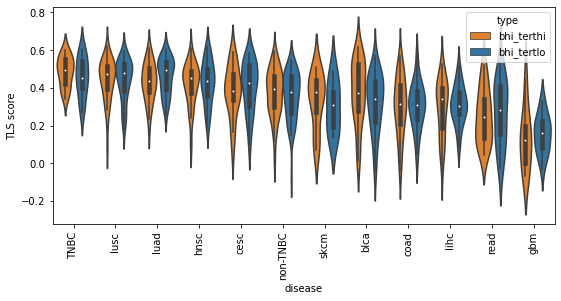

In [14]:
order = dfplot2.groupby("disease")["TLS score"].median().sort_values(ascending = False).index.tolist()
order.remove("brca")
plt.figure(figsize = (9,4))
g = sns.violinplot(x = "disease",
               y = "TLS score",
               data = dftmp,
               hue = "type",
               palette = [sns.color_palette("tab10")[1],sns.color_palette("tab10")[0]],
               order = order)
for label in g.get_xticklabels():
    label.set_rotation(90)


In [15]:
for disease in dftmp["disease"].unique():
    tmp = dftmp[dftmp.disease == disease]
    print(f'=={disease}==')
    print(sp.stats.ranksums(tmp[tmp["type"] == "bhi_terthi"]["TLS score"],
                            tmp[tmp["type"] == "bhi_tertlo"]["TLS score"]))

==hnsc==
RanksumsResult(statistic=-0.2804272736063897, pvalue=0.7791497148188524)
==lihc==
RanksumsResult(statistic=0.0, pvalue=1.0)
==lusc==
RanksumsResult(statistic=-0.0637947289504428, pvalue=0.9491336753995773)
==luad==
RanksumsResult(statistic=-1.508788074604818, pvalue=0.13135294926789212)
==blca==
RanksumsResult(statistic=1.5999221629185547, pvalue=0.10961585198247097)
==skcm==
RanksumsResult(statistic=0.5262348115842176, pvalue=0.5987250696528468)
==cesc==
RanksumsResult(statistic=-0.7550231826351125, pvalue=0.4502350724576881)
==coad==
RanksumsResult(statistic=0.2861465445558277, pvalue=0.7747658838248648)
==read==
RanksumsResult(statistic=-0.4666666666666667, pvalue=0.6407383818025407)
==gbm==
RanksumsResult(statistic=-0.8432740427115678, pvalue=0.3990751965482372)
==TNBC==
RanksumsResult(statistic=0.7921180343813395, pvalue=0.4282918554448939)
==non-TNBC==
RanksumsResult(statistic=0.648021629404138, pvalue=0.5169709608324395)


# Supplementary 5

In [16]:
def read_helper(genelist,tumor_type):
    
    refgene = "TERT"
    
    f = pd.read_csv("C:/Data/Lab/ZanettiLab/HNSC_TERT_project/data/rna_seq/"+tumor_type+"_all.rawcounts.csv",index_col=0)
    f.dropna(subset = ["genes"],inplace = True)
    f.set_index("genes",inplace = True)
    
    tert_exp = f.loc[refgene]
    tert_cut = pd.cut(tert_exp, bins = [-np.inf, np.quantile(tert_exp,q = .3), np.quantile(tert_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

    bcell = ["CD19","MS4A1"]
    b_exp = sp.stats.gmean(f.loc[bcell])
    b_cut = pd.cut(b_exp, bins = [-np.inf, np.quantile(b_exp,q = .3), np.quantile(b_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

    bhi_terthi = np.where((b_cut == "HIGH") & (tert_cut == "HIGH"))[0]
    bhi_terthi = list(f.columns[bhi_terthi])
    bhi_tertlo = np.where((b_cut == "HIGH") & (tert_cut == "LOW"))[0]
    bhi_tertlo = list(f.columns[bhi_tertlo])
    
    logfc = np.log2(f.loc[genelist][bhi_terthi].mean(axis=1) / f.loc[genelist][bhi_tertlo].mean(axis=1))
    return logfc

def fc_heatmap(hnsc_rnaseq = hnsc_rnaseq, brca_rnaseq = brca_rnaseq):
    
    refgene = "TERT"
    
    tert_exp = hnsc_rnaseq.loc[refgene]
    tert_cut = pd.cut(tert_exp, bins = [-np.inf, np.quantile(tert_exp,q = .3), np.quantile(tert_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

    bcell = ["CD19","MS4A1"]
    b_exp = sp.stats.gmean(hnsc_rnaseq.loc[bcell])
    b_cut = pd.cut(b_exp, bins = [-np.inf, np.quantile(b_exp,q = .3), np.quantile(b_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])


    bhi_terthi = np.where((b_cut == "HIGH") & (tert_cut == "HIGH"))[0]
    bhi_terthi = list(hnsc_rnaseq.columns[bhi_terthi])
    bhi_tertlo = np.where((b_cut == "HIGH") & (tert_cut == "LOW"))[0]
    bhi_tertlo = list(hnsc_rnaseq.columns[bhi_tertlo])
    
    hnsc_logfc = np.log2(hnsc_rnaseq.loc[genelist][bhi_terthi].mean(axis=1) / hnsc_rnaseq.loc[genelist][bhi_tertlo].mean(axis=1))
    
    other_d = {}
    for tumor in ["lihc","lusc","luad","blca","skcm","cesc","coad","read","gbm"]:
    #for tumor in ["blca","skcm"]:
        other_d[tumor.upper()] = read_helper(genelist = genelist,tumor_type=tumor)
    brca_d = tnbc_heatmap(brca_rnaseq)
    other_d["HNSC"] = hnsc_logfc
    other_d.update(brca_d)
    return pd.DataFrame(other_d)

def tnbc_heatmap(brca_rnaseq):
    brca_rnaseq = brca_rnaseq.set_index("genes").drop("0",axis=1)
    brca_rnaseq.columns = [map_d[x].split("-")[2] for x in brca_rnaseq.columns.tolist()]
    
    tnbc_ids = set(brca_subtypes[brca_subtypes["TNBC"] == "Positive"]["patient_id"]).intersection(brca_rnaseq.columns.tolist())
    non_tnbc_ids = set(brca_subtypes[brca_subtypes["TNBC"] == "Negative"]["patient_id"]).intersection(brca_rnaseq.columns.tolist())
    
    return_d = {}
    d = {"TNBC":tnbc_ids,
         "non-TNBC":non_tnbc_ids}
    
    refgene = "TERT"
    for ids in d.keys():
        df = brca_rnaseq[d[ids]]
        
        tert_exp = df.loc[refgene]
        tert_cut = pd.cut(tert_exp, bins = [-np.inf, np.quantile(tert_exp,q = .3), np.quantile(tert_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

        bcell = ["CD19","MS4A1"]
        b_exp = sp.stats.gmean(df.loc[bcell])
        b_cut = pd.cut(b_exp, bins = [-np.inf, np.quantile(b_exp,q = .3), np.quantile(b_exp,q = .7), np.inf], labels = ["LOW","MID","HIGH"])

        bhi_terthi = np.where((b_cut == "HIGH") & (tert_cut == "HIGH"))[0]
        bhi_terthi = list(df.columns[bhi_terthi])
        bhi_tertlo = np.where((b_cut == "HIGH") & (tert_cut == "LOW"))[0]
        bhi_tertlo = list(df.columns[bhi_tertlo])

        logfc = np.log2(df.loc[genelist][bhi_terthi].mean(axis=1) / df.loc[genelist][bhi_tertlo].mean(axis=1))
        return_d[ids] = logfc
    return return_d

In [17]:
df = fc_heatmap()

In [18]:
g2 = sns.clustermap(df)
plt.close()

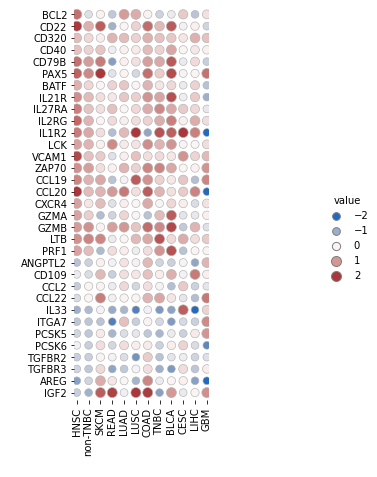

In [19]:
# Panel A
cols = ["HNSC","non-TNBC","SKCM","READ","LUAD","LUSC","COAD","TNBC","BLCA","CESC","LIHC","GBM"]
g = sns.relplot(
    data=g2.data2d.loc[genelist][cols].T.reset_index().melt(id_vars = ["index"]),
    x="index", y="genes", hue="value",  size="value",
    palette="vlag", hue_norm=(-2, 2), edgecolor=".7",
    height=6, sizes=(60, 100), size_norm=(-.2, .8),
)
# Tweak the figure to finalize
g.set(xlabel=" ", ylabel=" ", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".5")
fdir = "C:/Data/Lab/ZanettiLab/HNSC_TERT_project/data/rna_seq/result/"
#plt.savefig(fdir + "logfc_plot_ordered_v2.pdf",bbox_inches="tight")

In [20]:
# Panel B